In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

sns.set(
    { "figure.figsize": (17, 7) },
    style='ticks',
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [413]:
# Load the dataset
auto = pd.read_csv('adverts.csv')

# Price

In [414]:
# 9999999 prices are erroneous and should be removed
auto.loc[auto["price"].apply(lambda x: str(x).count('9') == len(str(x))), "price"] = np.nan

In [415]:
# Find extreme outliers that are likely erroneous

from sklearn.ensemble import IsolationForest

count = 0
for model_name in auto["standard_model"].unique():
    model_data = auto.loc[auto["standard_model"] == model_name, ["price"]]

    data_cropped = model_data.dropna(subset=["price"])

    fence_dist = 10
    # Step 2: Calculate IQR and Tukey’s Fences
    Q1 = data_cropped["price"].quantile(0.25)
    Q3 = data_cropped["price"].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - fence_dist * IQR
    upper_fence = Q3 + fence_dist * IQR
    data_cropped["outlier"] = (data_cropped["price"] < lower_fence) | (data_cropped["price"] > upper_fence)


    # Print outliers
    outliers = data_cropped.loc[data_cropped["outlier"]]
    

    if len(outliers) > 0:
        count += len(auto.loc[outliers.index, "price"])
        # Replace outlier values
        auto.loc[outliers.index, "price"] = np.nan

        # print(f"Outliers for {model_name}:\n", outliers)

        # plt.figure(figsize=(10, 6))
        # sns.boxplot(data=data_cropped, x="outlier", y="price")
        # plt.title(f"Outlier Detection for {model_name} Prices (Tukey’s Fences)", fontsize=16)
        # plt.xlabel("Outlier Status", fontsize=12)
        # plt.ylabel("Price", fontsize=12)
        # plt.tight_layout()
        # plt.show()
print(f"Replaced {count} outliers.")

Replaced 56 outliers.


In [416]:
# Drop nan prices.

# Public Reference

In [417]:
# Extract listing date from reference and then drop the column
auto['year_listed'] = auto['public_reference'].astype(str).str[:4]
auto['month_listed'] = auto['public_reference'].astype(str).str[4:6]
auto['day_listed'] = auto['public_reference'].astype(str).str[6:8]

auto.drop(columns=["public_reference"], inplace=True)

# Mileage

Outliers for 2013.0:
         mileage  outlier
43974  999999.0     True


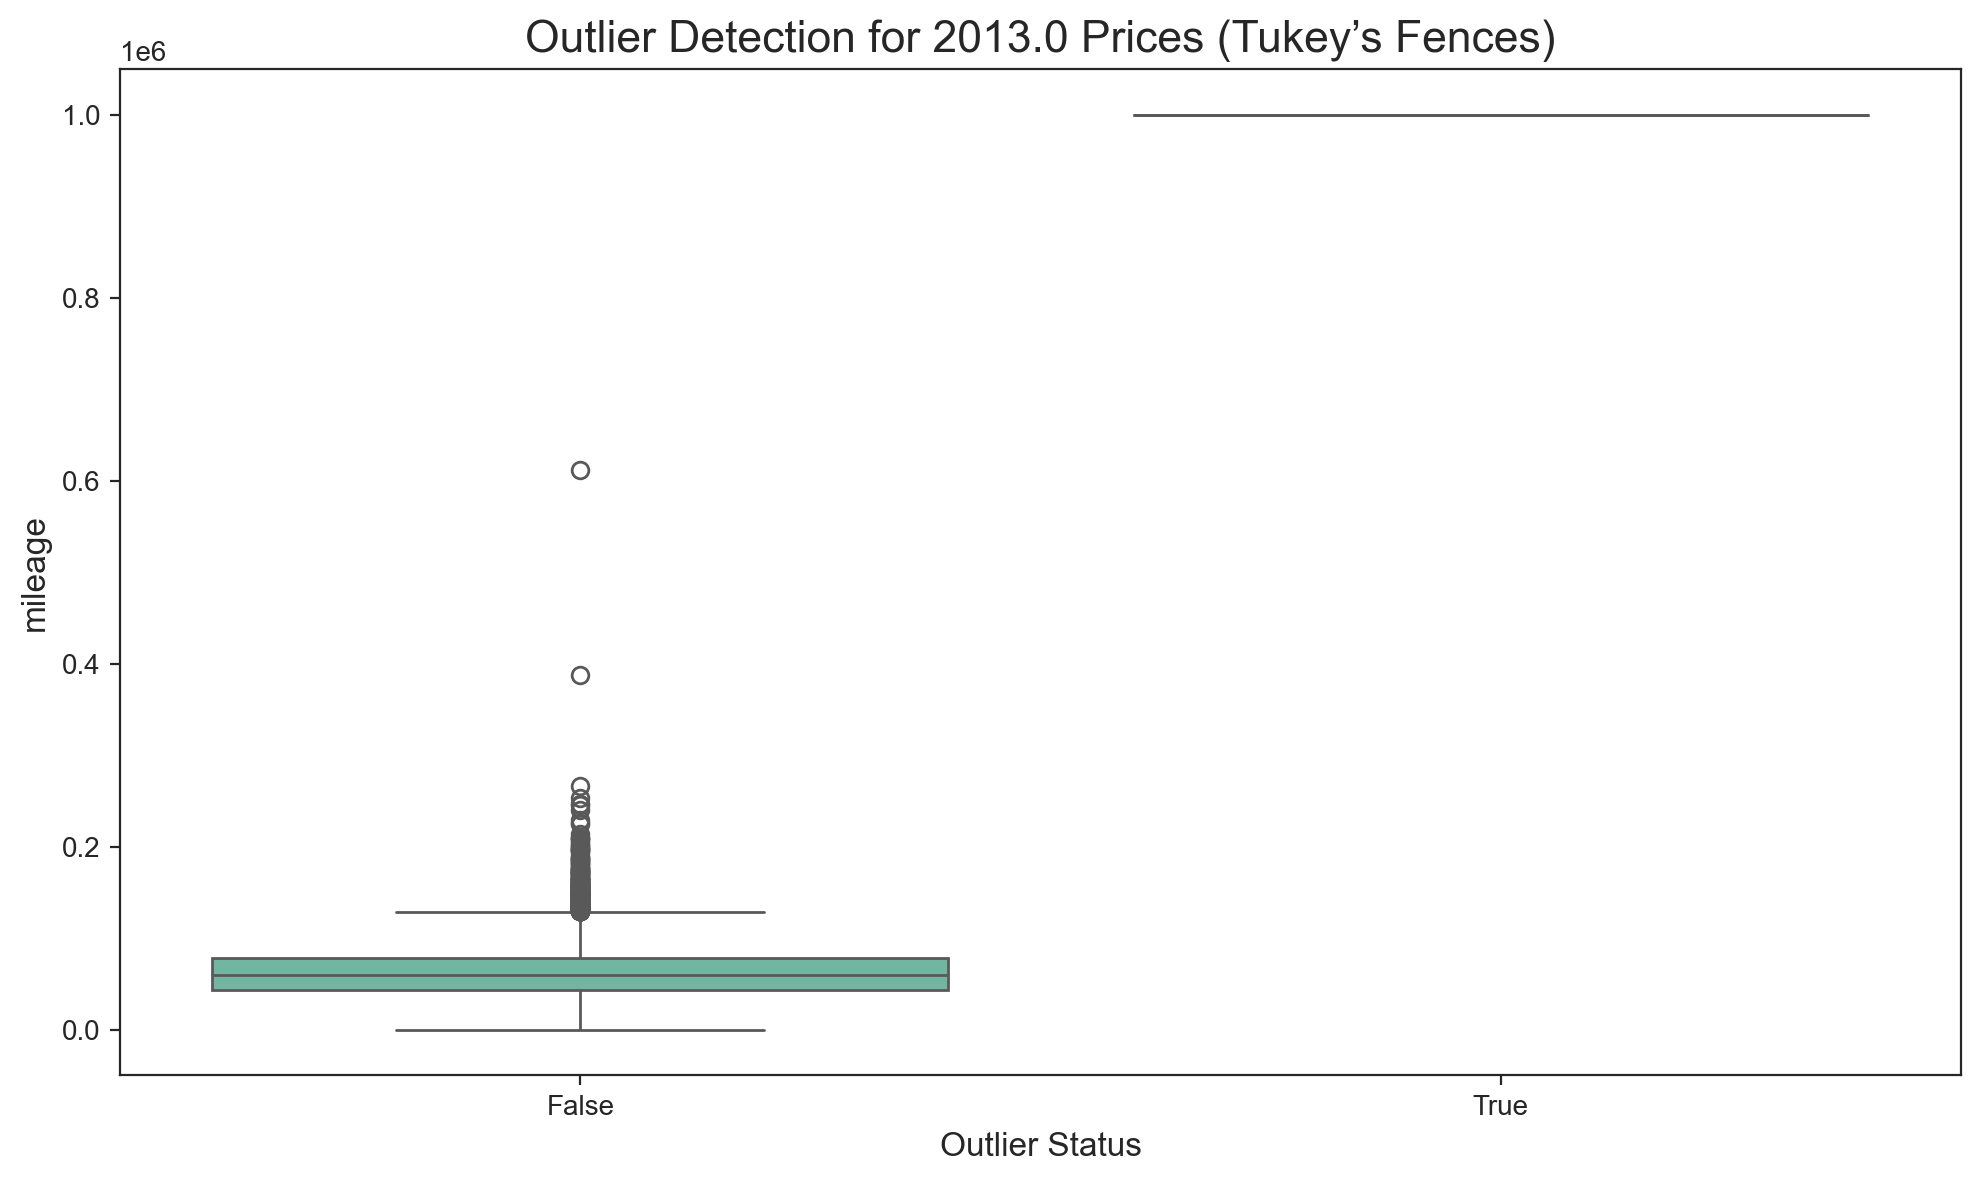

Outliers for 2019.0:
          mileage  outlier
117319  242000.0     True


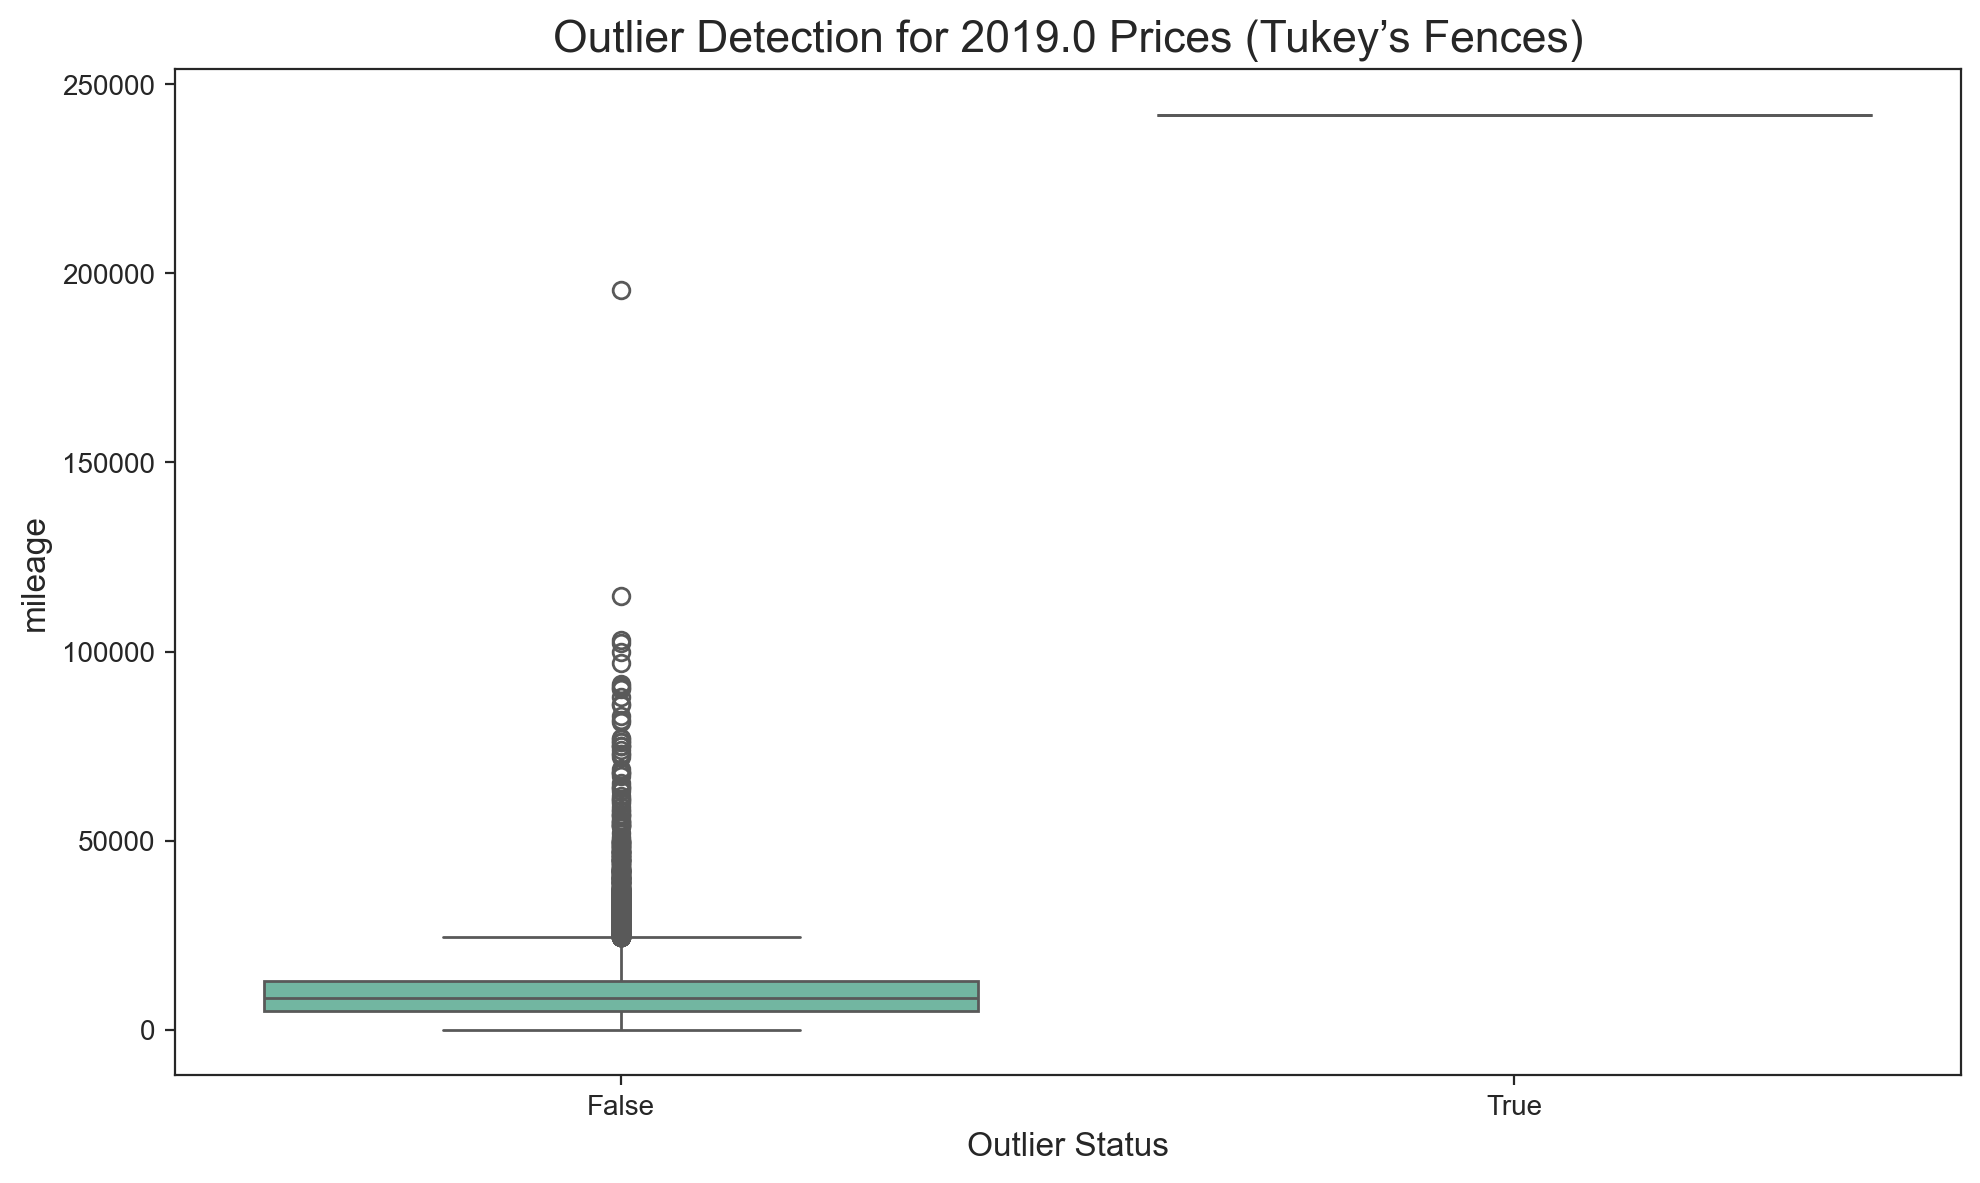

Outliers for 2018.0:
          mileage  outlier
131508  788072.0     True


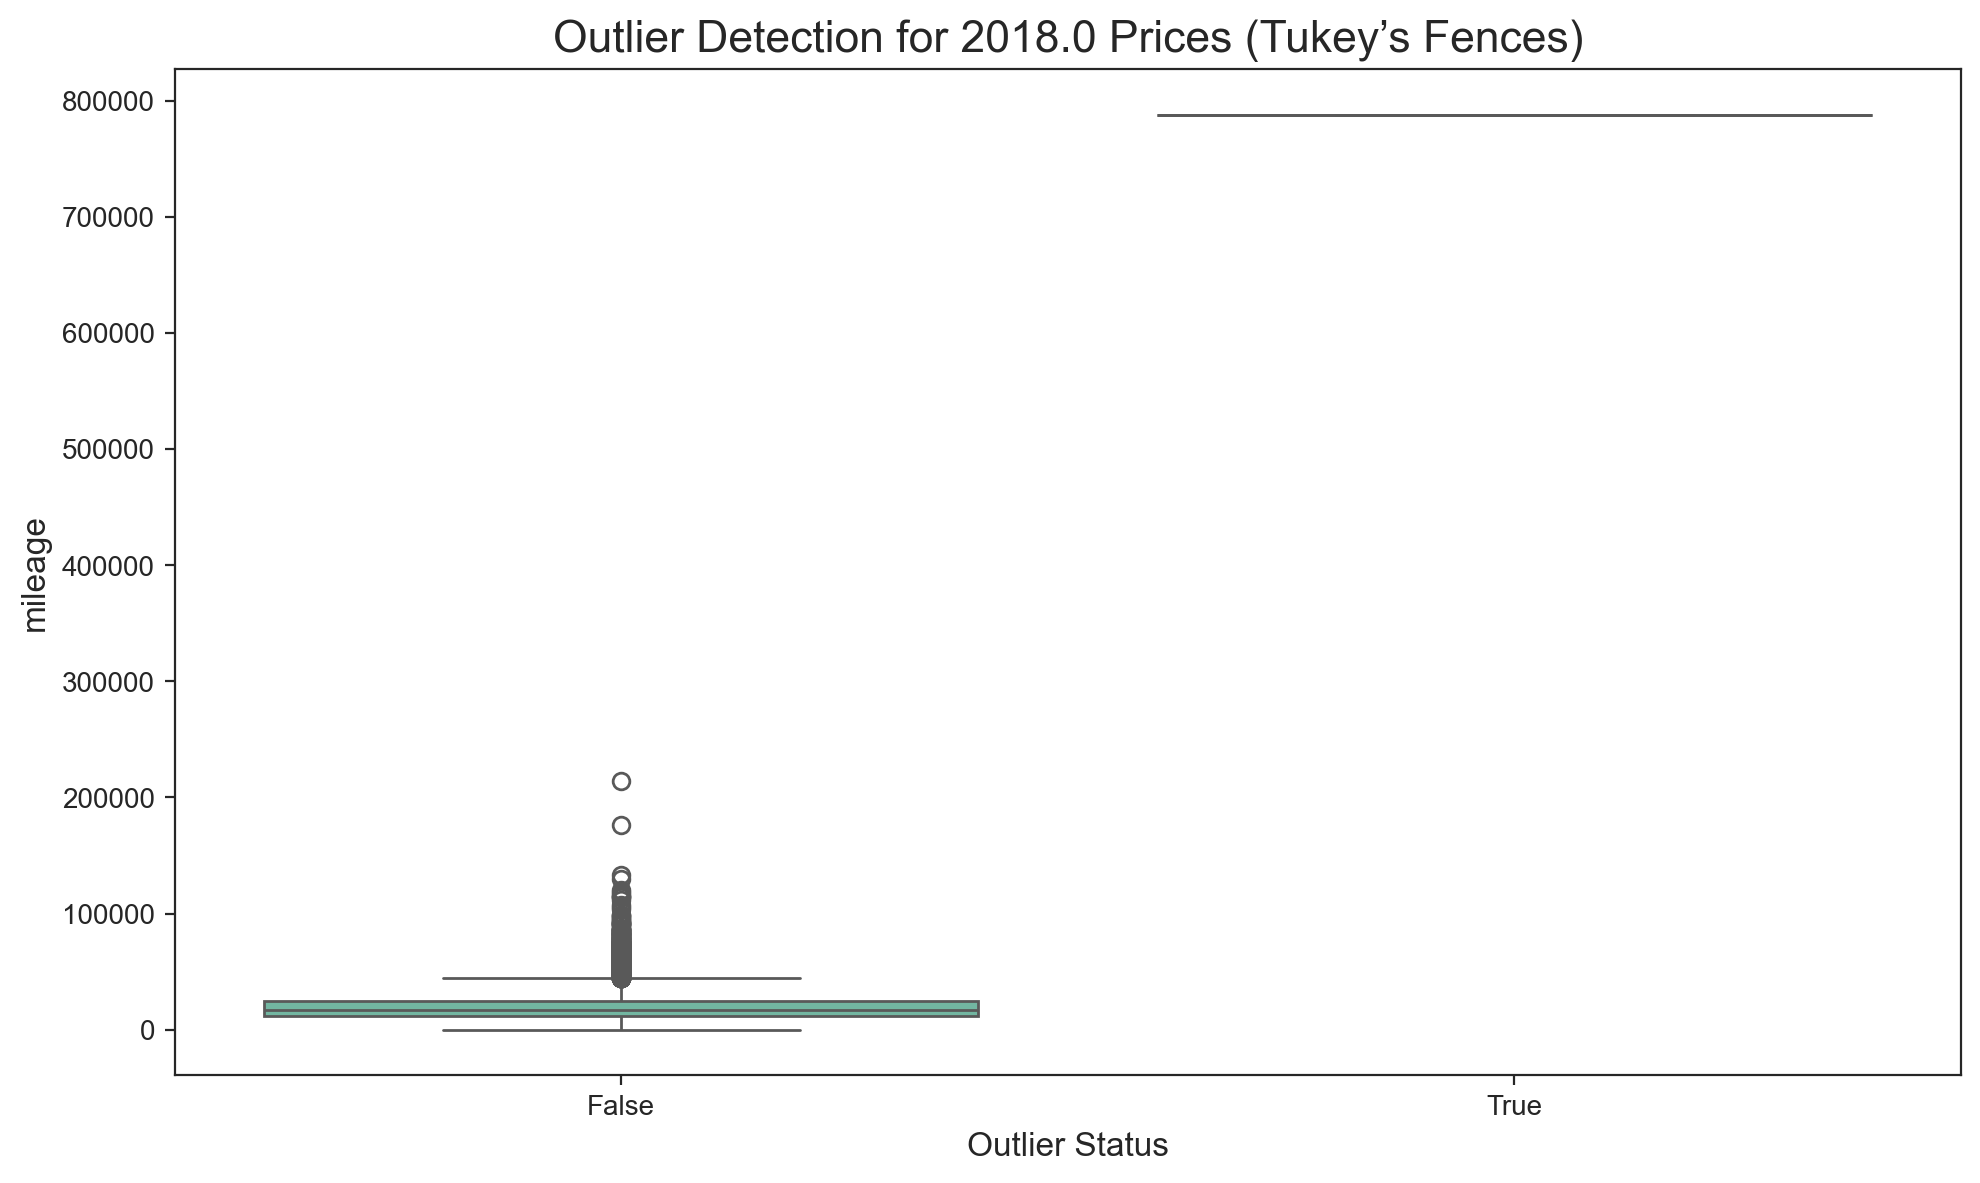

Outliers for 2020.0:
          mileage  outlier
85334   152000.0     True
104829  126602.0     True
148395  149000.0     True
157710  250000.0     True
164023  150000.0     True
173867  145000.0     True
254446  114000.0     True
285648  125250.0     True
346927  140000.0     True


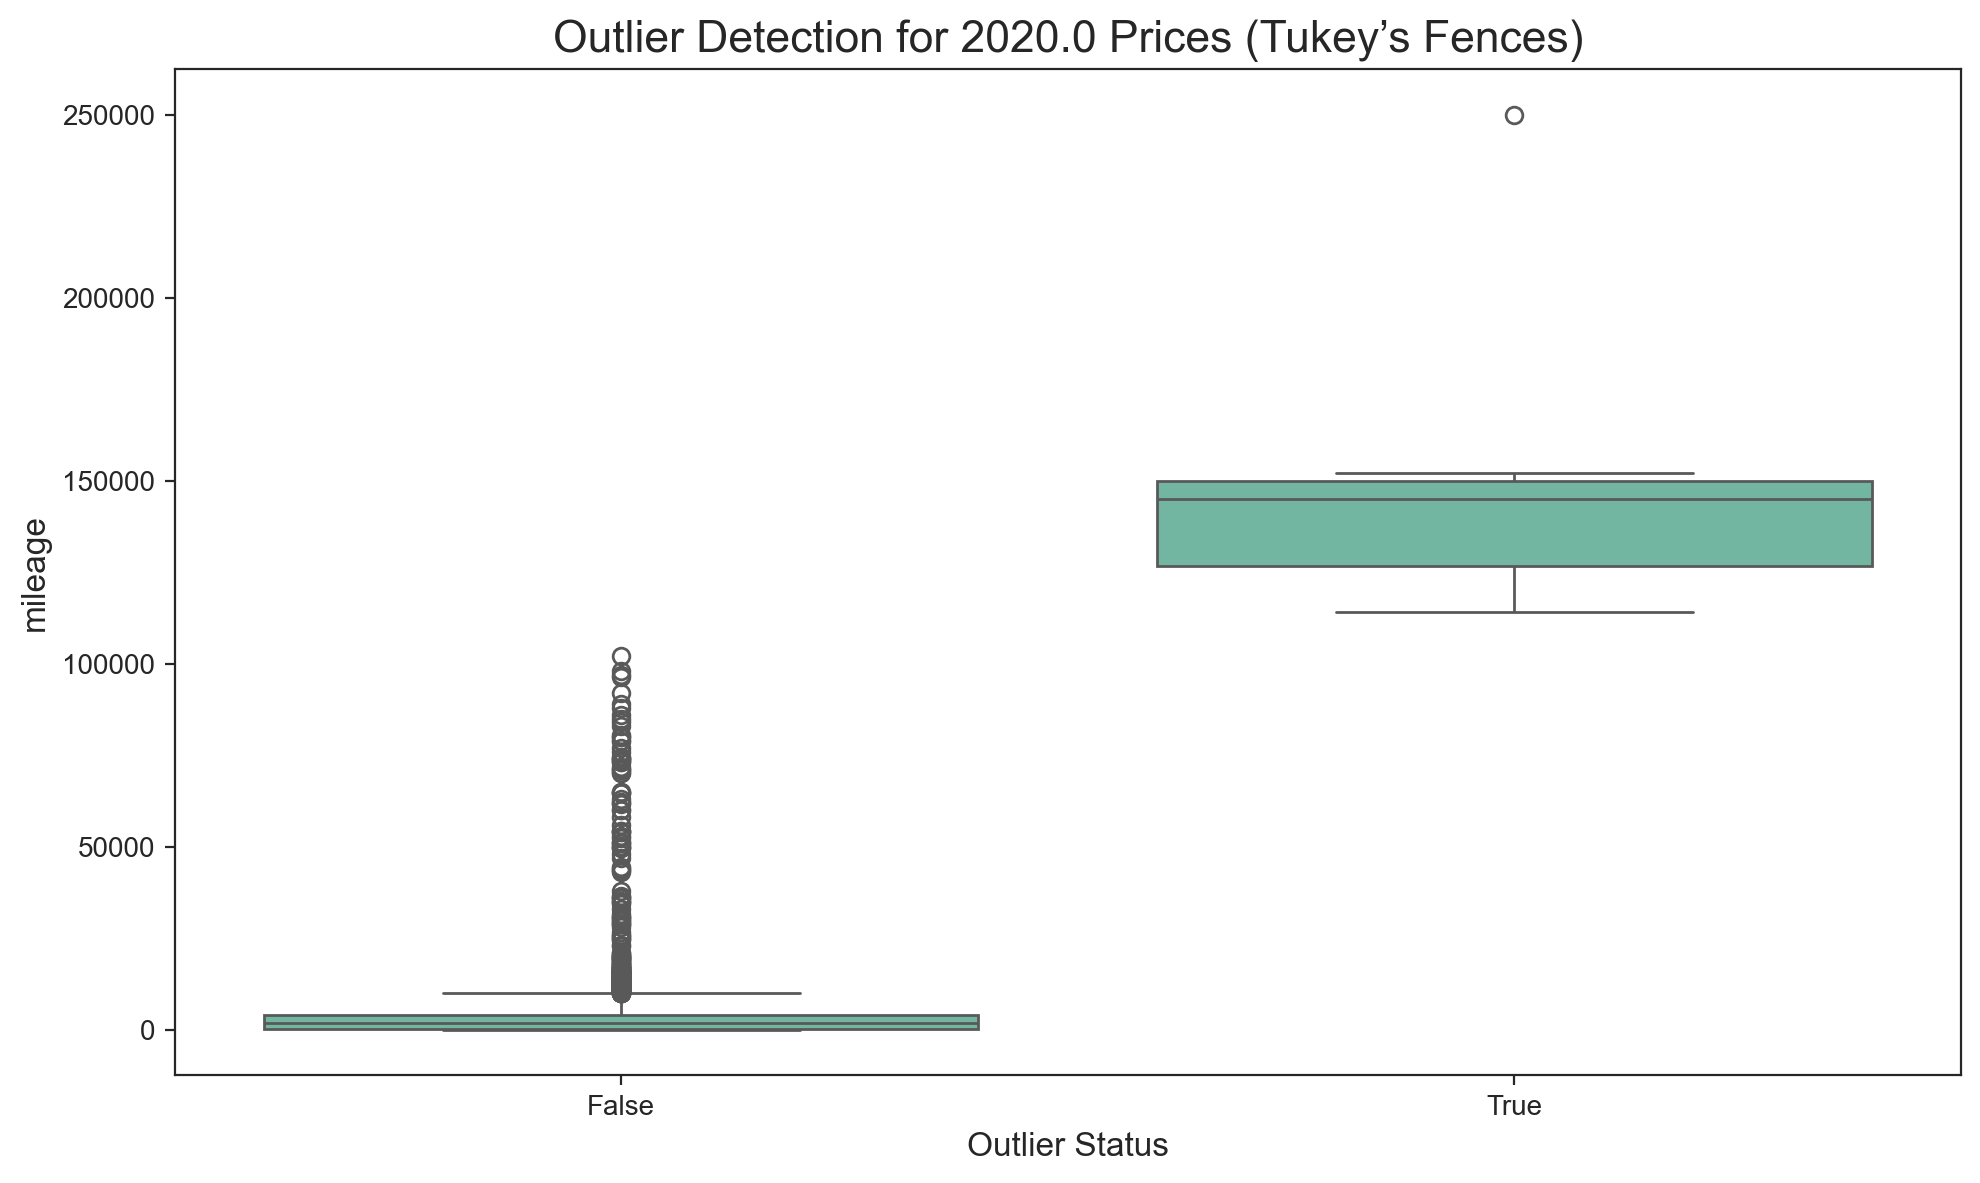

Replaced 12 outliers.


In [418]:
# Very large mileage entries
auto.loc[(auto["mileage"] > 0.3e6)].sort_values(by="mileage", ascending=False)

# Find extreme outliers that are likely erroneous

count = 0
for year in auto["year_of_registration"].unique():
    model_data = auto.loc[auto["year_of_registration"] == year, ["mileage"]]

    data_cropped = model_data.dropna(subset=["mileage"])

    fence_dist = 25
    # Step 2: Calculate IQR and Tukey’s Fences
    Q1 = data_cropped["mileage"].quantile(0.25)
    Q3 = data_cropped["mileage"].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - fence_dist * IQR
    upper_fence = Q3 + fence_dist * IQR
    data_cropped["outlier"] = (data_cropped["mileage"] < lower_fence) | (data_cropped["mileage"] > upper_fence)


    # Print outliers
    outliers = data_cropped.loc[data_cropped["outlier"]]
    

    if len(outliers) > 0:
        count += len(auto.loc[outliers.index, "mileage"])
        # # Replace outlier values
        # auto.loc[outliers.index, "mileage"] = np.nan

        print(f"Outliers for {year}:\n", outliers)

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data_cropped, x="outlier", y="mileage")
        plt.title(f"Outlier Detection for {year} Prices (Tukey’s Fences)", fontsize=16)
        plt.xlabel("Outlier Status", fontsize=12)
        plt.ylabel("mileage", fontsize=12)
        plt.tight_layout()
        plt.show()
print(f"Replaced {count} outliers.")

In [419]:
# Mileage of 0 is likely erroneous for older used cars
mask = (auto["mileage"] < 10) & (auto["vehicle_condition"] == "USED") & (auto["year_of_registration"] < 2018)
auto.loc[mask, "mileage"] = auto.loc[mask, "mileage"].replace(0, np.nan)

# Year of Registration

In [420]:
# Remove very old years for non-old makes
auto.loc[(auto["year_of_registration"] < 1950) & (~auto["standard_make"].isin(["Austin", "Morris"])), "year_of_registration"] = np.nan

In [421]:
# Set year of reg to 2020 for all new cars
auto.loc[(auto["vehicle_condition"] == "NEW"), "year_of_registration"] = 2020

# Registration Code

In [422]:
# Update missing years of reg based on the reg code
def reg_to_year(reg_code):
    try:
        reg_code = int(reg_code)
        if reg_code > 71 or (50 > reg_code > 20): return np.nan
        return 2000 + reg_code%50
    
    except ValueError:
        if not isinstance(reg_code, str): return np.nan
        
        letters = "ABCDEFGHJKLMNPRSTXY"
        if reg_code == "V": return (1979, 1999)
        if reg_code == "W": return (1980, 2000)
        if reg_code not in letters: return np.nan
        return (1983 + letters.find(reg_code), 1963 + letters.find(reg_code))
       

auto["reg_code_year"] = auto["reg_code"].map(reg_to_year)

In [423]:
def is_alpha(val):
    try: return not val.isnumeric()
    except: return False
    
missing = auto[(auto['reg_code'].apply(is_alpha)) & (auto["year_of_registration"].isna())]

In [424]:
# For each ambiguous year select the year closest to the mean for that make.
missing = missing.loc[missing["reg_code_year"].notna()]
full_missing = auto.loc[missing.index]

for i in range(len(full_missing)):
    missing_model = full_missing.iloc[i]["standard_model"]
    missing_make = full_missing.iloc[i]["standard_make"]
    years = full_missing.iloc[i]["reg_code_year"]
    used = auto.loc[(auto["standard_model"] == missing_model) & (auto["year_of_registration"].notna())]

    mean_year = np.array(used["year_of_registration"]).mean()
    closest_year = years[0] if abs(mean_year - years[0]) < abs(mean_year - years[1]) else years[1]

    auto.at[missing.index[i], "reg_code_year"] = closest_year

In [425]:
# Copy the year from the reg code for missing years then drop reg code and reg code year
auto.loc[auto["year_of_registration"].isna(), "year_of_registration"] = auto["reg_code_year"]

auto.drop(columns=["reg_code", "reg_code_year"], inplace=True)

# Encoding

In [426]:
auto["vehicle_condition"] = auto["vehicle_condition"].map({"NEW": 1, "USED": 0})
auto["crossover_car_and_van"] = auto["crossover_car_and_van"].map({True: 1, False: 0})

In [ ]:
from sklearn.impute import KNNImputer

def KNNCatagoricalImputer(n_neighbours=5):
    # Encode categories as integers
    data["standard_colour_encoded"] = data["standard_colour"].astype("category").cat.codes

    # Select columns for imputation
    columns_to_impute = ["standard_colour_encoded"]

    # Apply IterativeImputer
    imputer = KNNImputer(max_iter=10, random_state=42, missing_values=-1)
    imputed_data = imputer.fit_transform(data[columns_to_impute])


    # Replace the imputed column back into the DataFrame
    data["standard_colour_encoded"] = imputed_data[:, 0].round().astype(int)

    # Decode the imputed values back to original categories
    data["standard_colour"] = pd.Categorical.from_codes(
        data["standard_colour_encoded"],
        categories=data["standard_colour"].astype("category").cat.categories
    )

    data = data.drop(columns="standard_colour_encoded")

    data

,standard_colour,price,mileage
0,Red,5000.0,10000.0
1,Blue,7000.0,NaN
2,Green,8000.0,20000.0
3,Green,NaN,15000.0
4,Red,12000.0,12000.0


In [ ]:
auto

In [411]:
# Encode condition to two columns w/ one hot encoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
for col in ["standard_colour", "fuel_type"]:
    encoded_features = one_hot_encoder.fit_transform(auto[[col]])
    encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out([col]))
    auto = pd.concat([auto.drop(col, axis=1), encoded_df], axis=1)

auto = auto.drop(columns=["standard_colour_White", "fuel_type_Petrol"]) # Drop one column to avoid multicolinearity

In [339]:
# Encode text values to integers
label_encoder = OrdinalEncoder()
enc_columns = ['standard_make', 'standard_model', "body_type"]
endoded_data = label_encoder.fit_transform(auto[enc_columns])
auto[enc_columns] = endoded_data

# Scaling Values

In [340]:
# PowerTransformer for price and mileage
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Step 1: Apply PowerTransformer
transformed_data = pt.fit_transform(auto[['price', 'mileage', "year_of_registration"]])

# Step 2: Create a new DataFrame with transformed data
auto[['price', 'mileage', "year_of_registration"]] = transformed_data

In [341]:
# Robust scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

scaler = RobustScaler()

auto[auto.columns] = scaler.fit_transform(auto[auto.columns])

# Imputing Values

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=42)
auto[auto.columns] = imputer.fit_transform(auto[auto.columns])

# Export Clean Data

In [343]:
auto

,mileage,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,year_listed,month_listed,...,standard_colour_nan,fuel_type_Bi Fuel,fuel_type_Diesel,fuel_type_Diesel Hybrid,fuel_type_Diesel Plug-in Hybrid,fuel_type_Electric,fuel_type_Natural Gas,fuel_type_Petrol Hybrid,fuel_type_Petrol Plug-in Hybrid,fuel_type_nan
0,-1.646018,0.645161,1.017825,1.0,0.793476,1.944452,1.000000,0.0,0.0,-4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.056788,-0.306452,1.023173,0.0,-1.434240,-0.592621,1.166667,0.0,0.0,-3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.638364,0.403226,1.058824,0.0,0.000000,0.100718,1.000000,0.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.303319,0.612903,0.295900,0.0,-0.252763,-0.462857,0.000000,0.0,0.0,-3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.577007,-0.193548,0.529412,0.0,-0.499875,0.796675,1.000000,0.0,0.0,-3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402000,-0.784107,0.193548,-0.882353,0.0,0.522989,-0.183006,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402001,1.073121,0.193548,-0.944742,0.0,-1.870606,-1.745549,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402002,0.422579,0.096774,0.467023,0.0,-1.208524,-0.558503,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402003,-0.528264,-1.032258,-0.730838,0.0,-0.499875,-0.101141,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [344]:
auto.to_csv("adverts_clean.csv", index=False)